In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#import libraries

import os
import math
import cv2
import struct
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import xml.etree.ElementTree as ET

In [5]:
PROCESSED_DATA = './ICDAR/ICDAR_Processed'
IMAGE_PATH = os.path.join(PROCESSED_DATA, 'image')
TABLE_MASK_PATH = os.path.join(PROCESSED_DATA, 'table_mask')
COL_MASK_PATH = os.path.join(PROCESSED_DATA, 'col_mask')
ORIG_DATA_PATH = '.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth'

In [ ]:
os.makedirs(PROCESSED_DATA, exist_ok = True)
os.makedirs(IMAGE_PATH, exist_ok = True)
os.makedirs(TABLE_MASK_PATH, exist_ok = True)
os.makedirs(COL_MASK_PATH, exist_ok = True)

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('cTDaR_t00005.xml')
root = tree.getroot()

In [6]:
# Function to set a value in the table
def set_value(table, row, col, value):
    table[(row, col)] = value

# Function to get a value from the table
def get_value(table, row, col):
    return table.get((row, col), None)

# Point Extraction from XMLS

### Extraction and arrangement of points for columns from XMLs

In [49]:
import math
def parrange(start_row, start_col, end_row, end_col, pointsfornow, points):
  if(end_row == None):
    end_row = start_row
  if(end_col == None):
    end_col = start_col
  rows = end_row - start_row + 1
  cols = end_col - start_col + 1
  if(rows == 1 and cols == 1):
    set_value(pointsfornow, start_row, start_col, points[0:4])
    set_value(pointsfornow, start_row, start_col, [points[0], points[1], points[math.floor((len(points)-2)/2)+1], points[math.floor((len(points)-2)/2)+2]])
  elif (rows != 1 or cols != 1) and len(points) > 4:
    left = points[:rows+1]
    top = points[rows+1:rows+cols]
    right = points[rows+cols:rows+cols+rows+1]
    bottom = points[rows+cols+rows+1:]
    right.reverse()
    bottom.reverse()
    pts1 = True if len(points) == 2*(rows+cols) else False
    L1 = True if len(left) == rows+1 else False
    R1 = True if len(left) == rows+1 else False
    T1 = True if  len(top) == cols-1 else False
    B1 = True if  len(bottom) == cols-1 else False
    master = True if pts1 and L1 and R1 and T1 and B1 else False
    for row in range(rows):
      for col in range(cols):
        if col == 0 and cols > 1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [left[row], left[row+1], top[col], bottom[col]])
        elif col == cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], right[row], right[row+1]])
        elif col > 0 and col < cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], top[col], bottom[col]])
        else:
          set_value(pointsfornow, start_row+row, start_col+col, None)
  elif (rows != 1 or cols != 1):  
    for row in range(rows):
      for col in range(cols):
        set_value(pointsfornow, start_row+row, start_col+col, [points[0], points[1], points[2], points[3]])

In [8]:
def string_to_points(coord_string):
    points = coord_string.split()
    return [tuple(map(int, point.split(','))) for point in points]

In [9]:
def getall(root):
  table= []
  all_points = []
  max_col = []  # Variable to track the maximum end-col value

  for child in root: #Tables in Document
      pointsfornow = {}
      mxc = 0
      for child2 in child: #coord for table and cell in Table
        if 'points' in child2.attrib:
              table.append(string_to_points(child2.attrib['points']))
        else:
            start_row, start_col, end_row, end_col = None, None, None, None
            try:
              start_row = int(child2.attrib['start-row'])
              start_col = int(child2.attrib['start-col'])
              end_row = int(child2.attrib['end-row'])
              end_col = int(child2.attrib['end-col'])
            except(ValueError, TypeError):
              print("exception in Start/End Row/Column")
            try:
              if end_col > mxc:
                mxc = end_col
            except (ValueError, TypeError):
              print("exception in max col")
              if start_col > mxc:
                mxc = start_col
        for child3 in child2: #coord in Cell within Table
          if 'points' in child3.attrib:
                  parrange(start_row, start_col, end_row, end_col, pointsfornow, string_to_points(child3.attrib['points']))
      all_points.append(pointsfornow)
      max_col.append(mxc+1)
  return table, all_points, max_col 

## THIS is for COLUMN MASK ONLY

In [10]:
def customsort(points):
  toreturn = []
  for unsorted_dict in points:
    sorted_dict = dict(sorted(unsorted_dict.items(), key=lambda item: (item[0][0], item[0][1])))
    toreturn.append(sorted_dict)
  return toreturn

In [131]:
def toplot(all_ps, max_col):
    ret = []
    for p, all_poins in enumerate(all_ps):
      print(len(all_poins))
      # print(all_poins.keys())
      temp_ret = []
      resultant = list(all_poins.items())[-max_col[p]:]
      replacefrm = list(all_poins.items())[:max_col[p]]

# Iterate through the dictionary keys
      resultant = dict(resultant)
      replacefrm = dict(replacefrm)
      R1 = 0
      for key1 in resultant.keys():
        A = key1[0]
        if A > R1:
          R1 = A
      R2 = 1234567890123456789012345678901234567890
      for key2 in replacefrm.keys():
        B = key2[0]
        if B < R2:
          R2 = B
      # print(resultant)
      # print(replacefrm)
      # print(max_col[p], len(resultant), len(replacefrm))
      for i in range(max_col[p]):
        # j, k = 1, 1
        # res, rep = resultant[(R1, i)],  replacefrm[(R2, i)]
        j, k = 0, 0
        res, rep = None, None
        while res == None:
          # print("j:", j,"R1:", R1, all_poins[(R1 - j, i)])
          # print(all_poins[(R1 - j, i)])
          res= all_poins[(R1 - j, i)]
          j = j+1
          if(R1-j<0):
            res= False
        while rep == None:
          # print("k:", k,"R2:", R2, all_poins[(R2 + k, i)])
          rep = all_poins[(R2 + k, i)]
          k = k+1
          # if(R1+k>R1):
          try:
            all_poins[(R2 + k, i)]
          except:  
            rep= False
        if(rep == False and res == False):
          print("!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!")
        if(rep != False and res != False):
          res[0] = rep[0]
          res[3] = rep[3]
          res[0], res[1], res[2], res[3] = list(res[0]), list(res[1]), list(res[2]), list(res[3])
          res[0][0] += 20
          res[1][0] += 20
          res[2][0] -= 20
          res[3][0] -= 20
          res[0], res[1], res[2], res[3] = tuple(res[0]), tuple(res[1]), tuple(res[2]), tuple(res[3])
          temp_ret.append(res)
        # else:
        #   #REDUCE MAX_COL[P] BY 1
      #if:
      # max_col[p] = max_col[p]-1
      # print("temp_ret:" , temp_ret)
      ret.append(temp_ret)
    return ret

# Mask Generation

In [12]:
from PIL import Image, ImageDraw

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height

# EDA

## Marmot Dataset

We will be using data in terms of

- Positive Samples : Images with table in them
- Negative Samples : Images with no table in them

In [13]:
xmls = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.xml')
jpgs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.jpg')

In [14]:
xmls

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.xml',
 './ICDAR/IC

In [15]:
jpgs

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.jpg',
 './ICDAR/IC

In [ ]:
# Convert a PNG image to JPEG
def convert_png_to_jpg(png_file, jpg_file):
  """Converts a PNG image to a JPEG image.

  Args:
    png_file: The path to the PNG image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the PNG image.
  img = Image.open(png_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Convert a TIFF image to JPEG
def convert_tiff_to_jpg(tiff_file, jpg_file):
  """Converts a TIFF image to a JPEG image.

  Args:
    tiff_file: The path to the TIFF image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the TIFF image.
  img = Image.open(tiff_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Example usage:

# convert_png_to_jpg("image.png", "image.jpg")
# convert_tiff_to_jpg("image.tif", "image.jpg")

In [ ]:
tifs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.TIFF')
pngs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.png')

In [ ]:
tifs

In [ ]:
for i in tifs:
    input_path = i
    output_path = input_path.replace('.TIFF', '.jpg')
    convert_tiff_to_jpg(input_path, output_path)
    print(output_path)

In [ ]:
for i in pngs:
    input_path = i
    output_path = input_path.replace('.png', '.jpg')
    convert_png_to_jpg(input_path, output_path)
    print(output_path)

In [ ]:
len(xmls)

In [ ]:
len(jpgs)

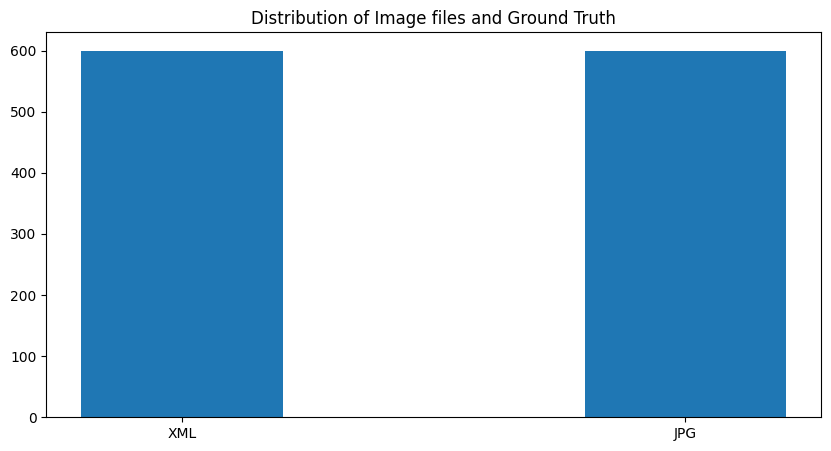

In [16]:
fig = plt.figure(figsize = (10, 5))

x = ['XML', 'JPG']
y = [len(xmls), len(jpgs)]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Image files and Ground Truth')
plt.show()

In [17]:
new_h, new_w = 1024, 1024

In [18]:
def tableplot(resultant, image_path, pathtosave):
# Define the size of the bitmap
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)

# Define the closed areas
  closed_areas = resultant
# Draw the closed areas in white
  for area in closed_areas:
    draw.polygon(area, fill='white')

# Save the image
  img.save(pathtosave)

def colplot(resultant, image_path, pathtosave):
# Define the size of the bitmap
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)

  for result in resultant:
  # Define the closed areas
    closed_areas = result
  # Draw the closed areas in white
    for area in closed_areas:
      draw.polygon(area, fill='white')

# Save the image
  img.save(pathtosave)

## Data Preprocessing

In [19]:
import xml.etree.ElementTree as ET

In [111]:
processed_data = []

In [112]:
# processed_data = []

for i, data in enumerate([jpgs]):
    
    for j, img_path in tqdm(enumerate(data)):
    #    if j > 99: 
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        w, h = image.size
        #convert to RGB image
        image = image.resize((new_h, new_w))
        if image.mode != 'RGB':
            image = image.convert("RGB")
        # table_bboxes, col_bboxes = [], []
            
        #get xml filename
        xml_file = image_name.replace('.jpg', '.xml')
        xml_file = xml_file.replace('.JPG', '.xml')
        xml_path = os.path.join(ORIG_DATA_PATH, xml_file)
        # xml_file.replace(" ", "")
        #processing XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
        print(j, xml_file)
        tables, all_points, max_col = getall(root)
        all_points = customsort(all_points)
        
        crds = toplot(all_points, max_col)
        # print(crds, tables)
        colmask, tablemask = os.path.join(COL_MASK_PATH, image_name), os.path.join(TABLE_MASK_PATH, image_name)
        colplot(crds, img_path, colmask)
        tableplot(tables, img_path, tablemask)
        value = (img_path, tablemask, colmask, h, w, int(tables != 0), \
                len(tables), len(crds), tables, crds)
        
        processed_data.append(value)
            # print(xml_path, w, h)
        # if j == 100:
            # break

1it [00:00,  3.75it/s]

0 cTDaR_t00000.xml


2it [00:00,  3.60it/s]

1 cTDaR_t00001.xml


3it [00:00,  3.48it/s]

2 cTDaR_t00002.xml
3 cTDaR_t00003.xml


4it [00:01,  3.34it/s]

4 cTDaR_t00004.xml


5it [00:01,  3.36it/s]

5 cTDaR_t00005.xml


6it [00:01,  3.31it/s]

6 cTDaR_t00006.xml


8it [00:02,  2.93it/s]

7 cTDaR_t00007.xml


9it [00:02,  3.17it/s]

8 cTDaR_t00008.xml


10it [00:03,  3.31it/s]

9 cTDaR_t00009.xml


11it [00:03,  3.27it/s]

10 cTDaR_t00010.xml


12it [00:03,  3.00it/s]

11 cTDaR_t00018.xml
12 cTDaR_t00019.xml


13it [00:04,  2.53it/s]

13 cTDaR_t00020.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


15it [00:05,  2.69it/s]

14 cTDaR_t00021.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


16it [00:05,  3.23it/s]

15 cTDaR_t00022.xml
16 cTDaR_t00023.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


17it [00:05,  2.77it/s]

17 cTDaR_t00024.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


19it [00:06,  2.39it/s]

18 cTDaR_t00025.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


20it [00:06,  2.61it/s]

19 cTDaR_t00026.xml
20 cTDaR_t00027.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


21it [00:07,  2.07it/s]

21 cTDaR_t00028.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


23it [00:08,  2.13it/s]

22 cTDaR_t00029.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


24it [00:09,  2.26it/s]

23 cTDaR_t00030.xml


25it [00:09,  2.38it/s]

24 cTDaR_t00031.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
25 cTDaR_t00032.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


27it [00:10,  2.74it/s]

26 cTDaR_t00033.xml


28it [00:10,  2.85it/s]

27 cTDaR_t00034.xml


29it [00:10,  2.53it/s]

28 cTDaR_t00035.xml


30it [00:11,  2.92it/s]

29 cTDaR_t00036.xml


31it [00:11,  2.68it/s]

30 cTDaR_t00037.xml


32it [00:11,  3.15it/s]

31 cTDaR_t00038.xml


33it [00:11,  3.49it/s]

32 cTDaR_t00039.xml
33 cTDaR_t00040.xml


35it [00:12,  4.16it/s]

34 cTDaR_t00041.xml


36it [00:12,  3.73it/s]

35 cTDaR_t00042.xml
36 cTDaR_t00043.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


37it [00:13,  2.90it/s]

37 cTDaR_t00044.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


39it [00:14,  2.65it/s]

38 cTDaR_t00045.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
39 cTDaR_t00046.xml


41it [00:14,  2.41it/s]

40 cTDaR_t00047.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


42it [00:15,  2.25it/s]

41 cTDaR_t00048.xml
42 cTDaR_t00049.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


43it [00:16,  2.10it/s]

43 cTDaR_t00050.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


45it [00:17,  1.65it/s]

44 cTDaR_t00051.xml
45 cTDaR_t00052.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


47it [00:18,  1.81it/s]

46 cTDaR_t00053.xml


48it [00:18,  1.99it/s]

47 cTDaR_t00054.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
48 cTDaR_t00055.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


49it [00:19,  1.96it/s]

49 cTDaR_t00056.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


51it [00:20,  2.28it/s]

50 cTDaR_t00057.xml


52it [00:20,  2.33it/s]

51 cTDaR_t00058.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


53it [00:20,  2.48it/s]

52 cTDaR_t00059.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


54it [00:21,  2.84it/s]

53 cTDaR_t00060.xml


55it [00:21,  2.48it/s]

54 cTDaR_t00061.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
55 cTDaR_t00062.xml


56it [00:22,  2.31it/s]

56 cTDaR_t00063.xml


58it [00:23,  2.18it/s]

57 cTDaR_t00064.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


59it [00:23,  2.15it/s]

58 cTDaR_t00065.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
59 cTDaR_t00066.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


61it [00:24,  2.01it/s]

60 cTDaR_t00067.xml


62it [00:25,  2.27it/s]

61 cTDaR_t00068.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
62 cTDaR_t00069.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


64it [00:26,  2.21it/s]

63 cTDaR_t00070.xml


65it [00:26,  2.31it/s]

64 cTDaR_t00091.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


66it [00:26,  2.40it/s]

65 cTDaR_t00092.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


67it [00:27,  2.46it/s]

66 cTDaR_t00093.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


68it [00:27,  2.50it/s]

67 cTDaR_t00094.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


69it [00:28,  2.54it/s]

68 cTDaR_t00095.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


70it [00:28,  2.57it/s]

69 cTDaR_t00096.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


71it [00:28,  2.65it/s]

70 cTDaR_t00097.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
71 cTDaR_t00098.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


72it [00:29,  2.30it/s]

72 cTDaR_t00099.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


73it [00:29,  2.04it/s]

73 cTDaR_t00100.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


75it [00:30,  2.16it/s]

74 cTDaR_t00101.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


76it [00:31,  2.47it/s]

75 cTDaR_t00116.xml


77it [00:31,  2.69it/s]

76 cTDaR_t00117.xml


78it [00:31,  2.94it/s]

77 cTDaR_t00118.xml


79it [00:31,  3.02it/s]

78 cTDaR_t00119.xml


80it [00:32,  3.14it/s]

79 cTDaR_t00120.xml


81it [00:32,  3.28it/s]

80 cTDaR_t00121.xml


82it [00:32,  3.40it/s]

81 cTDaR_t00122.xml
82 cTDaR_t00125.xml


83it [00:33,  1.77it/s]

83 cTDaR_t00126.xml


84it [00:35,  1.28it/s]

84 cTDaR_t00127.xml


85it [00:36,  1.07it/s]

85 cTDaR_t00128.xml


86it [00:37,  1.00it/s]

86 cTDaR_t00129.xml


87it [00:39,  1.11s/it]

87 cTDaR_t00130.xml


88it [00:40,  1.12s/it]

88 cTDaR_t00131.xml


89it [00:41,  1.18s/it]

89 cTDaR_t00132.xml


90it [00:42,  1.18s/it]

90 cTDaR_t00133.xml


91it [00:44,  1.24s/it]

91 cTDaR_t00134.xml


92it [00:45,  1.21s/it]

92 cTDaR_t00135.xml


93it [00:46,  1.21s/it]

93 cTDaR_t00136.xml


94it [00:47,  1.26s/it]

94 cTDaR_t00137.xml


95it [00:49,  1.29s/it]

95 cTDaR_t00138.xml


96it [00:50,  1.30s/it]

96 cTDaR_t00139.xml


97it [00:51,  1.33s/it]

97 cTDaR_t00140.xml


98it [00:53,  1.27s/it]

98 cTDaR_t00141.xml


99it [00:54,  1.30s/it]

99 cTDaR_t00142.xml


100it [00:55,  1.26s/it]

100 cTDaR_t00143.xml


101it [00:56,  1.25s/it]

101 cTDaR_t00144.xml


102it [00:58,  1.24s/it]

102 cTDaR_t00145.xml


103it [00:59,  1.23s/it]

103 cTDaR_t00167.xml


104it [00:59,  1.08s/it]

104 cTDaR_t00168.xml


105it [01:00,  1.01it/s]

105 cTDaR_t00169.xml


107it [01:02,  1.19it/s]

106 cTDaR_t00170.xml
107 cTDaR_t00171.xml


108it [01:02,  1.24it/s]

108 cTDaR_t00172.xml


109it [01:04,  1.14it/s]

109 cTDaR_t00173.xml


110it [01:05,  1.13s/it]

110 cTDaR_t00174.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


112it [01:07,  1.04it/s]

111 cTDaR_t00177.xml
112 cTDaR_t00178.xml


113it [01:07,  1.20it/s]

113 cTDaR_t00179.xml


114it [01:08,  1.28it/s]

114 cTDaR_t00180.xml


115it [01:09,  1.30it/s]

115 cTDaR_t00181.xml


117it [01:10,  1.68it/s]

116 cTDaR_t00182.xml


118it [01:10,  1.90it/s]

117 cTDaR_t00183.xml
118 cTDaR_t00184.xml


120it [01:11,  2.19it/s]

119 cTDaR_t00185.xml
120 cTDaR_t00186.xml


122it [01:12,  2.46it/s]

121 cTDaR_t00187.xml


123it [01:12,  2.60it/s]

122 cTDaR_t00188.xml


124it [01:12,  2.66it/s]

123 cTDaR_t00189.xml
124 cTDaR_t00190.xml


125it [01:13,  2.45it/s]

125 cTDaR_t00191.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


126it [01:13,  2.16it/s]

126 cTDaR_t00192.xml


127it [01:14,  1.68it/s]

127 cTDaR_t00198.xml


128it [01:15,  1.88it/s]

128 cTDaR_t00199.xml


129it [01:16,  1.25it/s]

129 cTDaR_t00200.xml


130it [01:17,  1.29it/s]

130 cTDaR_t00201.xml


131it [01:18,  1.29it/s]

131 cTDaR_t00202.xml


132it [01:18,  1.27it/s]

132 cTDaR_t00203.xml


133it [01:19,  1.31it/s]

133 cTDaR_t00204.xml


134it [01:20,  1.25it/s]

134 cTDaR_t00205.xml


135it [01:21,  1.23it/s]

135 cTDaR_t00206.xml


136it [01:22,  1.20it/s]

136 cTDaR_t00207.xml


137it [01:23,  1.21it/s]

137 cTDaR_t00208.xml


138it [01:23,  1.19it/s]

138 cTDaR_t00209.xml


139it [01:24,  1.16it/s]

139 cTDaR_t00228.xml


140it [01:25,  1.32it/s]

140 cTDaR_t00229.xml


141it [01:25,  1.51it/s]

141 cTDaR_t00230.xml


143it [01:26,  1.99it/s]

142 cTDaR_t00231.xml
143 cTDaR_t00232.xml


145it [01:28,  1.11it/s]

144 cTDaR_t00233.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


146it [01:29,  1.22it/s]

145 cTDaR_t00234.xml


147it [01:30,  1.11it/s]

146 cTDaR_t00235.xml


148it [01:31,  1.00s/it]

147 cTDaR_t00236.xml


149it [01:32,  1.00s/it]

148 cTDaR_t00237.xml


150it [01:34,  1.20s/it]

149 cTDaR_t00238.xml
150 cTDaR_t00239.xml


151it [01:36,  1.36s/it]

151 cTDaR_t00240.xml


152it [01:37,  1.27s/it]

152 cTDaR_t00241.xml


154it [01:39,  1.06s/it]

153 cTDaR_t00242.xml
154 cTDaR_t00243.xml


156it [01:44,  1.75s/it]

155 cTDaR_t00244.xml


157it [01:45,  1.45s/it]

156 cTDaR_t00245.xml
157 cTDaR_t00246.xml


158it [01:46,  1.32s/it]

158 cTDaR_t00247.xml


160it [01:48,  1.36s/it]

159 cTDaR_t00254.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


161it [01:50,  1.42s/it]

160 cTDaR_t00255.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
161 cTDaR_t00256.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


163it [01:51,  1.03s/it]

162 cTDaR_t00257.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


164it [01:52,  1.04it/s]

163 cTDaR_t00258.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


165it [01:54,  1.14s/it]

164 cTDaR_t00259.xml


166it [01:54,  1.04s/it]

165 cTDaR_t00260.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


167it [01:55,  1.06it/s]

166 cTDaR_t00261.xml


168it [01:57,  1.27s/it]

167 cTDaR_t00262.xml


169it [01:59,  1.37s/it]

168 cTDaR_t00263.xml


170it [02:00,  1.16s/it]

169 cTDaR_t00264.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
170 cTDaR_t00265.xml


172it [02:02,  1.17s/it]

171 cTDaR_t00266.xml


173it [02:04,  1.30s/it]

172 cTDaR_t00267.xml


174it [02:04,  1.16s/it]

173 cTDaR_t00268.xml


175it [02:05,  1.04s/it]

174 cTDaR_t00269.xml


176it [02:07,  1.29s/it]

175 cTDaR_t00270.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


177it [02:08,  1.05s/it]

176 cTDaR_t00271.xml


178it [02:10,  1.50s/it]

177 cTDaR_t00272.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


179it [02:15,  2.47s/it]

178 cTDaR_t00273.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


180it [02:21,  3.62s/it]

179 cTDaR_t00274.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


181it [02:25,  3.59s/it]

180 cTDaR_t00275.xml
181 cTDaR_t00276.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


182it [02:30,  4.07s/it]

182 cTDaR_t00277.xml


184it [02:36,  3.53s/it]

183 cTDaR_t00278.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


185it [02:37,  2.76s/it]

184 cTDaR_t00279.xml
185 cTDaR_t00280.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


187it [02:38,  1.64s/it]

186 cTDaR_t00281.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


188it [02:40,  1.71s/it]

187 cTDaR_t00282.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


189it [02:42,  1.66s/it]

188 cTDaR_t00283.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


190it [02:43,  1.43s/it]

189 cTDaR_t00284.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
190 cTDaR_t00304.xml


191it [02:45,  1.80s/it]

191 cTDaR_t00305.xml


192it [02:49,  2.22s/it]

192 cTDaR_t00306.xml


193it [02:53,  3.00s/it]

193 cTDaR_t00307.xml


194it [02:55,  2.70s/it]

194 cTDaR_t00308.xml


195it [02:57,  2.43s/it]

195 cTDaR_t00309.xml


196it [02:59,  2.26s/it]

196 cTDaR_t00310.xml


197it [03:01,  2.25s/it]

197 cTDaR_t00311.xml


198it [03:03,  2.04s/it]

198 cTDaR_t00312.xml


199it [03:05,  2.03s/it]

199 cTDaR_t00313.xml


200it [03:07,  2.04s/it]

200 cTDaR_t00314.xml


201it [03:09,  1.90s/it]

201 cTDaR_t00315.xml


202it [03:11,  1.92s/it]

202 cTDaR_t00316.xml


203it [03:12,  1.81s/it]

203 cTDaR_t00317.xml


204it [03:14,  1.80s/it]

204 cTDaR_t00318.xml


205it [03:16,  1.80s/it]

205 cTDaR_t00319.xml


206it [03:19,  2.25s/it]

206 cTDaR_t00320.xml


207it [03:21,  2.13s/it]

207 cTDaR_t00321.xml


208it [03:23,  2.16s/it]

208 cTDaR_t00343.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


209it [03:24,  1.85s/it]

209 cTDaR_t00344.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


210it [03:26,  1.70s/it]

210 cTDaR_t00345.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


211it [03:27,  1.68s/it]

211 cTDaR_t00346.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


212it [03:28,  1.43s/it]

212 cTDaR_t00347.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


213it [03:29,  1.33s/it]

213 cTDaR_t00348.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


214it [03:31,  1.52s/it]

214 cTDaR_t00349.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


215it [03:33,  1.59s/it]

215 cTDaR_t00350.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


216it [03:34,  1.59s/it]

216 cTDaR_t00351.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


217it [03:35,  1.43s/it]

217 cTDaR_t00352.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


218it [03:37,  1.54s/it]

218 cTDaR_t00353.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


219it [03:38,  1.32s/it]

219 cTDaR_t00354.xml


220it [03:39,  1.28s/it]

220 cTDaR_t00355.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


221it [03:42,  1.67s/it]

221 cTDaR_t00356.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


222it [03:43,  1.64s/it]

222 cTDaR_t00357.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


223it [03:45,  1.68s/it]

223 cTDaR_t00358.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


224it [03:47,  1.67s/it]

224 cTDaR_t00359.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


225it [03:48,  1.54s/it]

225 cTDaR_t00360.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


226it [03:49,  1.40s/it]

226 cTDaR_t00361.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


227it [03:51,  1.51s/it]

227 cTDaR_t00362.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


228it [03:52,  1.47s/it]

228 cTDaR_t00363.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


229it [03:54,  1.54s/it]

229 cTDaR_t00364.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


230it [03:56,  1.71s/it]

230 cTDaR_t00365.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


231it [03:58,  1.88s/it]

231 cTDaR_t00366.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


232it [04:00,  1.70s/it]

232 cTDaR_t00367.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


233it [04:01,  1.48s/it]

233 cTDaR_t00368.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


234it [04:02,  1.56s/it]

234 cTDaR_t00369.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


235it [04:03,  1.44s/it]

235 cTDaR_t00370.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


236it [04:05,  1.53s/it]

236 cTDaR_t00371.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


237it [04:06,  1.45s/it]

237 cTDaR_t00372.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


238it [04:08,  1.33s/it]

238 cTDaR_t00373.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


239it [04:09,  1.34s/it]

239 cTDaR_t00388.xml


240it [04:10,  1.35s/it]

240 cTDaR_t00389.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


241it [04:12,  1.60s/it]

241 cTDaR_t00390.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


243it [04:14,  1.30s/it]

242 cTDaR_t00391.xml


244it [04:15,  1.14s/it]

243 cTDaR_t00392.xml


245it [04:16,  1.06it/s]

244 cTDaR_t00393.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


246it [04:17,  1.10s/it]

245 cTDaR_t00394.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
246 cTDaR_t00395.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


247it [04:18,  1.02it/s]

247 cTDaR_t00396.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


248it [04:20,  1.28s/it]

248 cTDaR_t00397.xml


250it [04:22,  1.19s/it]

249 cTDaR_t00398.xml


251it [04:25,  1.66s/it]

250 cTDaR_t00403.xml
251 cTDaR_t00404.xml


253it [04:30,  2.12s/it]

252 cTDaR_t00405.xml
253 cTDaR_t00406.xml


254it [04:33,  2.26s/it]

254 cTDaR_t00407.xml


256it [04:40,  2.75s/it]

255 cTDaR_t00408.xml


257it [04:47,  4.18s/it]

256 cTDaR_t00409.xml


258it [04:51,  4.19s/it]

257 cTDaR_t00410.xml


259it [04:52,  3.26s/it]

258 cTDaR_t00411.xml


260it [04:53,  2.61s/it]

259 cTDaR_t00412.xml
260 cTDaR_t00413.xml


261it [04:56,  2.69s/it]

261 cTDaR_t00414.xml


262it [04:59,  2.78s/it]

262 cTDaR_t00415.xml


264it [05:02,  1.93s/it]

263 cTDaR_t00416.xml


265it [05:05,  2.39s/it]

264 cTDaR_t00417.xml


266it [05:06,  1.94s/it]

265 cTDaR_t00418.xml
266 cTDaR_t00419.xml


267it [05:09,  2.22s/it]

267 cTDaR_t00420.xml


269it [05:12,  1.90s/it]

268 cTDaR_t00421.xml


270it [05:14,  1.80s/it]

269 cTDaR_t00422.xml


271it [05:16,  1.91s/it]

270 cTDaR_t00423.xml
271 cTDaR_t00424.xml


273it [05:19,  1.73s/it]

272 cTDaR_t00425.xml
273 cTDaR_t00426.xml


275it [05:22,  1.52s/it]

274 cTDaR_t00427.xml


276it [05:23,  1.41s/it]

275 cTDaR_t00428.xml


277it [05:24,  1.32s/it]

276 cTDaR_t00429.xml


278it [05:25,  1.20s/it]

277 cTDaR_t00430.xml


279it [05:26,  1.07s/it]

278 cTDaR_t00431.xml


280it [05:27,  1.08s/it]

279 cTDaR_t00432.xml


281it [05:27,  1.01it/s]

280 cTDaR_t00433.xml


282it [05:28,  1.09it/s]

281 cTDaR_t00434.xml


283it [05:29,  1.10it/s]

282 cTDaR_t00435.xml


284it [05:30,  1.08it/s]

283 cTDaR_t00436.xml


285it [05:31,  1.05s/it]

284 cTDaR_t00437.xml


286it [05:33,  1.10s/it]

285 cTDaR_t00438.xml


287it [05:34,  1.12s/it]

286 cTDaR_t00439.xml


288it [05:35,  1.16s/it]

287 cTDaR_t00440.xml


289it [05:36,  1.07s/it]

288 cTDaR_t00441.xml


290it [05:37,  1.16s/it]

289 cTDaR_t00442.xml


291it [05:38,  1.08s/it]

290 cTDaR_t00443.xml


292it [05:39,  1.11it/s]

291 cTDaR_t00448.xml


293it [05:39,  1.22it/s]

292 cTDaR_t00449.xml


294it [05:40,  1.25it/s]

293 cTDaR_t00450.xml


295it [05:41,  1.24it/s]

294 cTDaR_t00451.xml


296it [05:42,  1.06it/s]

295 cTDaR_t00452.xml


297it [05:43,  1.08it/s]

296 cTDaR_t00453.xml


298it [05:44,  1.10it/s]

297 cTDaR_t00454.xml


299it [05:45,  1.17it/s]

298 cTDaR_t00455.xml


300it [05:45,  1.22it/s]

299 cTDaR_t00456.xml


301it [05:46,  1.12it/s]

300 cTDaR_t00457.xml


302it [05:47,  1.17it/s]

301 cTDaR_t00458.xml


303it [05:48,  1.18it/s]

302 cTDaR_t00459.xml


304it [05:49,  1.21it/s]

303 cTDaR_t00460.xml
304 cTDaR_t00461.xml


306it [05:50,  1.24it/s]

305 cTDaR_t00462.xml


307it [05:51,  1.29it/s]

306 cTDaR_t00463.xml


308it [05:52,  1.23it/s]

307 cTDaR_t00464.xml


309it [05:53,  1.21it/s]

308 cTDaR_t00465.xml


310it [05:54,  1.23it/s]

309 cTDaR_t00466.xml


311it [05:54,  1.27it/s]

310 cTDaR_t00467.xml


312it [05:56,  1.04it/s]

311 cTDaR_t00468.xml
312 cTDaR_t00469.xml


314it [06:02,  1.99s/it]

313 cTDaR_t00470.xml
314 cTDaR_t00471.xml


316it [06:05,  1.99s/it]

315 cTDaR_t00472.xml


317it [06:09,  2.49s/it]

316 cTDaR_t00473.xml


318it [06:12,  2.64s/it]

317 cTDaR_t00474.xml


319it [06:15,  2.83s/it]

318 cTDaR_t00475.xml


320it [06:16,  2.19s/it]

319 cTDaR_t00476.xml


321it [06:17,  1.80s/it]

320 cTDaR_t00501.xml
321 cTDaR_t00502.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


323it [06:19,  1.35s/it]

322 cTDaR_t00503.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
323 cTDaR_t00504.xml


324it [06:20,  1.15s/it]

324 cTDaR_t00505.xml


325it [06:21,  1.29s/it]

325 cTDaR_t00506.xml


327it [06:24,  1.21s/it]

326 cTDaR_t00507.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


328it [06:26,  1.61s/it]

327 cTDaR_t00508.xml
328 cTDaR_t00509.xml


330it [06:30,  1.76s/it]

329 cTDaR_t00510.xml


331it [06:32,  1.66s/it]

330 cTDaR_t00511.xml
331 cTDaR_t00512.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


332it [06:34,  1.78s/it]

332 cTDaR_t00513.xml


334it [06:38,  2.09s/it]

333 cTDaR_t00514.xml
334 cTDaR_t00515.xml


336it [06:41,  1.68s/it]

335 cTDaR_t00516.xml
336 cTDaR_t00517.xml


338it [06:45,  1.67s/it]

337 cTDaR_t00518.xml


339it [06:46,  1.59s/it]

338 cTDaR_t00519.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


340it [06:47,  1.41s/it]

339 cTDaR_t00520.xml
340 cTDaR_t00521.xml


341it [06:49,  1.47s/it]

341 cTDaR_t00522.xml


343it [06:51,  1.19s/it]

342 cTDaR_t00530.xml


344it [06:52,  1.16s/it]

343 cTDaR_t00531.xml


345it [06:52,  1.02s/it]

344 cTDaR_t00532.xml


346it [06:53,  1.09it/s]

345 cTDaR_t00533.xml
346 cTDaR_t00534.xml


347it [06:54,  1.02it/s]

347 cTDaR_t00535.xml


349it [06:56,  1.24it/s]

348 cTDaR_t00536.xml


350it [06:56,  1.33it/s]

349 cTDaR_t00537.xml


351it [06:57,  1.31it/s]

350 cTDaR_t00538.xml


352it [06:58,  1.32it/s]

351 cTDaR_t00539.xml


353it [06:59,  1.21it/s]

352 cTDaR_t00540.xml


354it [06:59,  1.29it/s]

353 cTDaR_t00541.xml
354 cTDaR_t00542.xml


355it [07:01,  1.11it/s]

355 cTDaR_t00543.xml


357it [07:02,  1.16it/s]

356 cTDaR_t00544.xml
357 cTDaR_t00545.xml


359it [07:04,  1.09it/s]

358 cTDaR_t00546.xml


360it [07:06,  1.14s/it]

359 cTDaR_t00547.xml
360 cTDaR_t00548.xml


362it [07:11,  1.82s/it]

361 cTDaR_t00549.xml


363it [07:14,  2.05s/it]

362 cTDaR_t00550.xml
363 cTDaR_t00551.xml


365it [07:20,  2.48s/it]

364 cTDaR_t00552.xml


366it [07:22,  2.35s/it]

365 cTDaR_t00553.xml


367it [07:24,  2.48s/it]

366 cTDaR_t00554.xml
367 cTDaR_t00555.xml


369it [07:29,  2.34s/it]

368 cTDaR_t00556.xml
369 cTDaR_t00557.xml


371it [07:37,  3.26s/it]

370 cTDaR_t00558.xml
371 cTDaR_t00559.xml


373it [07:44,  3.38s/it]

372 cTDaR_t00560.xml
373 cTDaR_t00561.xml


374it [07:45,  2.66s/it]

374 cTDaR_t00562.xml


376it [07:49,  2.43s/it]

375 cTDaR_t00563.xml


377it [07:50,  1.96s/it]

376 cTDaR_t00564.xml


378it [07:54,  2.43s/it]

377 cTDaR_t00565.xml
378 cTDaR_t00566.xml


380it [07:59,  2.36s/it]

379 cTDaR_t00567.xml
380 cTDaR_t00568.xml


382it [08:01,  1.73s/it]

381 cTDaR_t00569.xml


383it [08:03,  1.91s/it]

382 cTDaR_t00570.xml


384it [08:04,  1.56s/it]

383 cTDaR_t00571.xml
384 cTDaR_t00572.xml


385it [08:06,  1.69s/it]

385 cTDaR_t00573.xml


387it [08:08,  1.38s/it]

386 cTDaR_t00574.xml
387 cTDaR_t00575.xml


389it [08:11,  1.34s/it]

388 cTDaR_t00576.xml


390it [08:11,  1.10s/it]

389 cTDaR_t00577.xml


391it [08:12,  1.09it/s]

390 cTDaR_t00578.xml


392it [08:12,  1.28it/s]

391 cTDaR_t00579.xml


393it [08:13,  1.35it/s]

392 cTDaR_t00580.xml


394it [08:13,  1.49it/s]

393 cTDaR_t00581.xml


395it [08:14,  1.58it/s]

394 cTDaR_t00582.xml


396it [08:14,  1.68it/s]

395 cTDaR_t00583.xml


397it [08:15,  1.69it/s]

396 cTDaR_t00584.xml


398it [08:15,  1.82it/s]

397 cTDaR_t00585.xml


399it [08:17,  1.43it/s]

398 cTDaR_t00586.xml


400it [08:17,  1.40it/s]

399 cTDaR_t00587.xml


401it [08:18,  1.23it/s]

400 cTDaR_t00588.xml


402it [08:19,  1.26it/s]

401 cTDaR_t00589.xml


403it [08:20,  1.25it/s]

402 cTDaR_t00590.xml


404it [08:21,  1.28it/s]

403 cTDaR_t00591.xml


405it [08:21,  1.24it/s]

404 cTDaR_t00592.xml


406it [08:22,  1.31it/s]

405 cTDaR_t00593.xml


407it [08:23,  1.38it/s]

406 cTDaR_t00594.xml


408it [08:23,  1.52it/s]

407 cTDaR_t00595.xml


409it [08:24,  1.49it/s]

408 cTDaR_t00596.xml


410it [08:25,  1.55it/s]

409 cTDaR_t00597.xml


411it [08:25,  1.68it/s]

410 cTDaR_t00598.xml


412it [08:26,  1.78it/s]

411 cTDaR_t00599.xml
412 cTDaR_t00600.xml


413it [08:28,  1.23s/it]

413 cTDaR_t00601.xml


414it [08:31,  1.52s/it]

414 cTDaR_t00602.xml


415it [08:32,  1.46s/it]

415 cTDaR_t00603.xml


416it [08:33,  1.41s/it]

416 cTDaR_t00604.xml


417it [08:35,  1.46s/it]

417 cTDaR_t00605.xml


418it [08:37,  1.65s/it]

418 cTDaR_t00606.xml


419it [08:39,  1.74s/it]

419 cTDaR_t00607.xml


420it [08:40,  1.67s/it]

420 cTDaR_t00608.xml


421it [08:42,  1.78s/it]

421 cTDaR_t00609.xml


423it [08:46,  1.79s/it]

422 cTDaR_t00610.xml
423 cTDaR_t00611.xml


425it [08:49,  1.56s/it]

424 cTDaR_t00612.xml
425 cTDaR_t00613.xml


427it [08:52,  1.53s/it]

426 cTDaR_t00614.xml


428it [08:53,  1.34s/it]

427 cTDaR_t00615.xml


429it [08:53,  1.13s/it]

428 cTDaR_t00616.xml


430it [08:56,  1.57s/it]

429 cTDaR_t00617.xml


431it [08:57,  1.47s/it]

430 cTDaR_t00618.xml


432it [08:58,  1.31s/it]

431 cTDaR_t00619.xml


433it [08:59,  1.14s/it]

432 cTDaR_t00620.xml
433 cTDaR_t00641.xml


434it [09:00,  1.23s/it]

434 cTDaR_t00642.xml


435it [09:04,  1.99s/it]

435 cTDaR_t00643.xml


437it [09:14,  3.46s/it]

436 cTDaR_t00644.xml


438it [09:16,  3.11s/it]

437 cTDaR_t00645.xml


439it [09:16,  2.33s/it]

438 cTDaR_t00646.xml


440it [09:18,  1.98s/it]

439 cTDaR_t00647.xml


441it [09:19,  1.64s/it]

440 cTDaR_t00650.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


442it [09:19,  1.26s/it]

441 cTDaR_t00651.xml
442 cTDaR_t00652.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


443it [09:20,  1.29s/it]

443 cTDaR_t00653.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


445it [09:22,  1.20s/it]

444 cTDaR_t00654.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
445 cTDaR_t00655.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


447it [09:25,  1.19s/it]

446 cTDaR_t00656.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
447 cTDaR_t00657.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


448it [09:26,  1.12s/it]

448 cTDaR_t00658.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


450it [09:30,  1.77s/it]

449 cTDaR_t00662.xml


451it [09:36,  2.88s/it]

450 cTDaR_t00663.xml
451 cTDaR_t00664.xml


453it [09:42,  2.90s/it]

452 cTDaR_t00665.xml
453 cTDaR_t00666.xml


454it [09:44,  2.81s/it]

454 cTDaR_t00667.xml


455it [09:46,  2.61s/it]

455 cTDaR_t00668.xml


457it [09:51,  2.40s/it]

456 cTDaR_t00669.xml


458it [09:52,  2.10s/it]

457 cTDaR_t00670.xml
458 cTDaR_t00671.xml


460it [09:55,  1.70s/it]

459 cTDaR_t00672.xml


461it [09:57,  1.64s/it]

460 cTDaR_t00673.xml


462it [09:59,  1.96s/it]

461 cTDaR_t00674.xml
462 cTDaR_t00675.xml


464it [10:01,  1.51s/it]

463 cTDaR_t00676.xml
464 cTDaR_t00677.xml


465it [10:03,  1.54s/it]

465 cTDaR_t00678.xml


466it [10:04,  1.47s/it]

466 cTDaR_t00679.xml


467it [10:06,  1.46s/it]

467 cTDaR_t00708.xml


469it [10:08,  1.28s/it]

468 cTDaR_t00709.xml
469 cTDaR_t00710.xml


471it [10:19,  3.91s/it]

470 cTDaR_t00711.xml


472it [10:46, 10.65s/it]

471 cTDaR_t00712.xml
472 cTDaR_t00713.xml


474it [11:21, 13.38s/it]

473 cTDaR_t00714.xml
474 cTDaR_t00715.xml


476it [11:48, 12.71s/it]

475 cTDaR_t00716.xml


477it [11:51,  9.81s/it]

476 cTDaR_t00717.xml
477 cTDaR_t00718.xml


478it [11:56,  8.28s/it]

478 cTDaR_t00719.xml


479it [12:01,  7.49s/it]

479 cTDaR_t00760.xml


481it [12:17,  7.82s/it]

480 cTDaR_t00761.xml
481 cTDaR_t00762.xml


483it [12:43, 10.82s/it]

482 cTDaR_t00763.xml
483 cTDaR_t00764.xml


484it [12:48,  9.23s/it]

484 cTDaR_t00765.xml


485it [12:54,  8.29s/it]

485 cTDaR_t00766.xml


486it [12:57,  6.52s/it]

486 cTDaR_t00767.xml


488it [12:59,  3.73s/it]

487 cTDaR_t00768.xml


489it [13:00,  2.78s/it]

488 cTDaR_t00769.xml
489 cTDaR_t00770.xml


491it [13:01,  1.77s/it]

490 cTDaR_t00771.xml


492it [13:02,  1.42s/it]

491 cTDaR_t00772.xml
492 cTDaR_t00799.xml


494it [13:04,  1.21s/it]

493 cTDaR_t00800.xml
494 cTDaR_t00801.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


495it [13:05,  1.07s/it]

495 cTDaR_t00802.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


497it [13:06,  1.05it/s]

496 cTDaR_t00803.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


498it [13:07,  1.07it/s]

497 cTDaR_t00804.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
498 cTDaR_t00805.xml


499it [13:09,  1.05s/it]

499 cTDaR_t00806.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


500it [13:10,  1.10s/it]

500 cTDaR_t00807.xml


502it [13:12,  1.16s/it]

501 cTDaR_t00808.xml
502 cTDaR_t00809.xml


503it [13:13,  1.05s/it]

503 cTDaR_t00815.xml


504it [13:14,  1.04s/it]

504 cTDaR_t00816.xml


505it [13:16,  1.17s/it]

505 cTDaR_t00817.xml


506it [13:18,  1.64s/it]

506 cTDaR_t00818.xml


507it [13:25,  2.99s/it]

507 cTDaR_t00819.xml


508it [13:28,  3.10s/it]

508 cTDaR_t00820.xml


509it [13:33,  1.60s/it]

509 cTDaR_t00821.xml


KeyError: (75, 3)

In [113]:
column_name = ['img_path','table_mask','col_mask','original_height','original_width','hasTable','table_count','col_count','table_bboxes','col_bboxes']
processed_data = pd.DataFrame(processed_data, columns=column_name)

In [114]:
processed_data.to_csv("processed_data_ICDAR.csv", index = False)

In [115]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00000.jpg,3584,4912,1,1,1,"[[(1722, 698), (3961, 698), (3961, 3247), (172...","[[[(1742, 698), (1695, 3239), (1740, 3239), (1..."
1,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00001.jpg,3584,4912,1,2,2,"[[(130, 538), (2398, 615), (2327, 3112), (128,...","[[[(129, 542), (69, 3073), (106, 3073), (153, ..."
2,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00002.jpg,3584,4912,1,2,2,"[[(149, 521), (2425, 639), (2317, 3117), (163,...","[[[(162, 526), (138, 1173), (48, 3065), (182, ..."
3,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00003.jpg,3584,4912,1,2,2,"[[(296, 237), (2461, 473), (2209, 3015), (346,...","[[[(323, 228), (33, 2780), (97, 2792), (363, 2..."
4,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00004.jpg,3584,4912,1,2,2,"[[(169, 374), (2278, 462), (2265, 3022), (180,...","[[[(183, 385), (85, 3064), (145, 3064), (231, ..."


In [116]:
processed_data = pd.read_csv('processed_data_ICDAR.csv')

In [117]:
processed_data.describe()

,original_height,original_width,hasTable,table_count,col_count
count,509.000000,509.000000,509.0,509.000000,509.000000
mean,4105.412574,4020.762279,1.0,1.123772,1.123772
std,964.617293,1745.301742,0.0,0.423712,0.423712
min,1977.000000,1386.000000,1.0,1.000000,1.000000
25%,3584.000000,2734.000000,1.0,1.000000,1.000000
50%,3873.000000,3251.000000,1.0,1.000000,1.000000
75%,4689.000000,4912.000000,1.0,1.000000,1.000000
max,7662.000000,8487.000000,1.0,4.000000,4.000000


In [118]:
len(processed_data)

509

## Advanced EDA

In [ ]:
processed_data['hasTable'].value_counts().tolist()

#### Positive : Negative Ratio

In [ ]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
data = processed_data['hasTable'].value_counts().tolist()
y = [data[1],data[0]]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Columns without any Table

In [ ]:
processed_data[(processed_data['table_count']==0)]

#### Table with No Columns

In [ ]:
processed_data[(processed_data['hasTable']==1) & (processed_data['col_count']==0)]

#### plotting image with table but no columns

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2010_5.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2107_9.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.160.669_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_8.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

### Observations

- There are 5 images with tables but no columns
- There are total 494 Negative Samples and 499 Positive Samples.
- Also, we confirmed that there are no columns with only tables.

### Height of the Image

In [ ]:
processed_data['original_height'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_height'], color='b', fill=True)
  
plt.xlabel('Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Image

In [ ]:
processed_data['original_width'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_width'], color='b', fill=True)

plt.xlabel('Width')
plt.ylabel('Probability Density')
plt.show()

### Total Tables

In [ ]:
processed_data['table_count'].value_counts().plot.bar()
plt.xlabel('Tables')
plt.ylabel('Count')
plt.show()

### Total Columns

In [ ]:
processed_data['col_count'].value_counts().plot.bar()
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [ ]:
import json


### Observations

- Height of most images are between 1000 - 1100
- Width of most images are between 700-800.
- Apart from images with no Tables, most images contains only 1 table and at maximum 4 tables.
- Total Columns in an image (can have multiple tables in a page) ranges from 4 - 42
- We have also seen Image with no columns but have Tables in them.

### Height of Table

In [ ]:
heights = []
widths = []
for boxes in processed_data[processed_data['hasTable']==1]['table_bboxes']:
    # boxes = [json.loads('[' + boxes.strip('][').strip(',') + ']')]
    print(boxes)
# Convert the cleaned string to a Python list
# array = json.loads('[' + cleaned_string + ']')
    # for box in boxes:
    #     heights.append(box[3]-box[1])
    #     widths.append(box[2]-box[0])

In [ ]:
min(col_widths)

In [ ]:
sns.histplot(heights, color='b', Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(heights, color='b', shade=True, Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Table

In [ ]:
sns.histplot(widths, color='b', Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(widths, color='b', shade=True, Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Probability Density')
plt.show()

### Height of the Column

In [ ]:
col_heights = []
col_widths = []
for boxes in processed_data[processed_data['hasTable']==1]['col_bboxes']:
    for box in boxes:
        col_heights.append(box[3]-box[1])
        col_widths.append(box[2]-box[0])

In [ ]:
sns.histplot(col_heights, color='b', Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_heights, color='b', shade=True, Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Column

In [ ]:
sns.histplot(col_widths, color='b', Label='Column Width')

plt.xlabel('Column Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_widths, color='b', shade=True, Label='Table Column')

plt.xlabel('Table Column')
plt.ylabel('Probability Density')
plt.show()

### Observations

- Height of tables ranges from 30 - 870, but most are between  50-300.
- Width of tables ranges from 50 - 900, but common width is 400.
- Height of columns ranges from 10 - 880 showing a right skewed distribution
- Width of columns ranges from 7 - 671 showing a right skewed distribution

In [108]:
xml_file1 = "cTDaR_t00199.jpg"
xml_file1 = image_name.replace('.jpg', '.xml')
xml_file1 = image_name.replace('.JPG', '.xml')
xml1_file = os.path.join(ORIG_DATA_PATH, xml_file1)
print(xml1_file)

xml1_file.replace(" ", "")
tree1 = ET.parse(xml1_file)
root1 = tree1.getroot()

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00199.xml


In [101]:
root1

<Element 'document' at 0x000002BD0F0A3C40>

In [93]:
tree1


In [119]:
type(xmls)

list

In [120]:
xmls[-1:]

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00930.xml']

In [125]:
test = jpgs[-92:]

In [126]:
test[0]

'./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00820.jpg'

In [127]:
test[-1]

'./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00930.jpg'

In [133]:
def toplot_2(all_ps, max_col):
    ret = []
    for p, all_poins in enumerate(all_ps):
      print(len(all_poins))
      # print(all_poins.keys())
      temp_ret = []
      resultant = list(all_poins.items())[-max_col[p]:]
      replacefrm = list(all_poins.items())[:max_col[p]]

# Iterate through the dictionary keys
      resultant = dict(resultant)
      replacefrm = dict(replacefrm)
      R1 = 0
      for key1 in resultant.keys():
        A = key1[0]
        if A > R1:
          R1 = A
      R2 = 1234567890123456789012345678901234567890
      for key2 in replacefrm.keys():
        B = key2[0]
        if B < R2:
          R2 = B
      # print(resultant)
      # print(replacefrm)
      # print(max_col[p], len(resultant), len(replacefrm))
      for i in range(max_col[p]):
        # j, k = 1, 1
        # res, rep = resultant[(R1, i)],  replacefrm[(R2, i)]
        j, k = 0, 0
        res, rep = None, None
        while res == None:
          # print("j:", j,"R1:", R1, all_poins[(R1 - j, i)])
          # print(all_poins[(R1 - j, i)])
          try:
            res=all_poins[(R1 - j, i)]
          except:  
            j=j+1
          res= all_poins[(R1 - j, i)]
          j = j+1
          if(R1-j<0):
            res= False
        while rep == None:
          # print("k:", k,"R2:", R2, all_poins[(R2 + k, i)])
          rep = all_poins[(R2 + k, i)]
          k = k+1
          # if(R1+k>R1):
          try:
            all_poins[(R2 + k, i)]
          except:  
            rep= False
        if(rep == False and res == False):
          print("!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!")
        if(rep != False and res != False):
          res[0] = rep[0]
          res[3] = rep[3]
          res[0], res[1], res[2], res[3] = list(res[0]), list(res[1]), list(res[2]), list(res[3])
          res[0][0] += 20
          res[1][0] += 20
          res[2][0] -= 20
          res[3][0] -= 20
          res[0], res[1], res[2], res[3] = tuple(res[0]), tuple(res[1]), tuple(res[2]), tuple(res[3])
          temp_ret.append(res)
        # else:
        #   #REDUCE MAX_COL[P] BY 1
      #if:
      # max_col[p] = max_col[p]-1
      # print("temp_ret:" , temp_ret)
      ret.append(temp_ret)
    return ret

In [129]:
further_proces = []

In [134]:
for i, data in enumerate([test]):
    
    for j, img_path in tqdm(enumerate(data)):
    #    if j > 99: 
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        w, h = image.size
        #convert to RGB image
        image = image.resize((new_h, new_w))
        if image.mode != 'RGB':
            image = image.convert("RGB")
        # table_bboxes, col_bboxes = [], []
            
        #get xml filename
        xml_file = image_name.replace('.jpg', '.xml')
        xml_file = xml_file.replace('.JPG', '.xml')
        xml_path = os.path.join(ORIG_DATA_PATH, xml_file)
        # xml_file.replace(" ", "")
        #processing XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
        print(j, xml_file)
        tables, all_points, max_col = getall(root)
        all_points = customsort(all_points)
        
        crds = toplot_2(all_points, max_col)
        # print(crds, tables)
        colmask, tablemask = os.path.join(COL_MASK_PATH, image_name), os.path.join(TABLE_MASK_PATH, image_name)
        colplot(crds, img_path, colmask)
        tableplot(tables, img_path, tablemask)
        value = (img_path, tablemask, colmask, h, w, int(tables != 0), \
                len(tables), len(crds), tables, crds)
        
        further_proces.append(value)


0it [00:00, ?it/s]

0 cTDaR_t00820.xml
312
352
240


1it [00:00,  1.52it/s]

1 cTDaR_t00821.xml
316
303


2it [00:01,  1.42it/s]

2 cTDaR_t00822.xml
320
348
240


3it [00:02,  1.04s/it]

3 cTDaR_t00823.xml
316
352
240


4it [00:04,  1.11s/it]

4 cTDaR_t00824.xml
320
304


5it [00:05,  1.07s/it]

5 cTDaR_t00825.xml
316
352
240


6it [00:06,  1.07s/it]

6 cTDaR_t00826.xml
316
300


7it [00:07,  1.07s/it]

7 cTDaR_t00827.xml
316
352
244


8it [00:09,  1.35s/it]

8 cTDaR_t00841.xml
589


9it [00:12,  1.82s/it]

9 cTDaR_t00842.xml
620


10it [00:13,  1.77s/it]

10 cTDaR_t00843.xml
682


11it [00:15,  1.70s/it]

11 cTDaR_t00844.xml
620


12it [00:16,  1.64s/it]

12 cTDaR_t00845.xml
713


13it [00:18,  1.62s/it]

13 cTDaR_t00846.xml
245


14it [00:20,  1.72s/it]

14 cTDaR_t00851.xml
64
64


16it [00:22,  1.28s/it]

15 cTDaR_t00852.xml
24
24
21
18


17it [00:22,  1.15s/it]

16 cTDaR_t00853.xml
9
17 cTDaR_t00854.xml
512


18it [00:23,  1.12s/it]

18 cTDaR_t00855.xml
30
35


19it [00:25,  1.26s/it]

19 cTDaR_t00856.xml
165


20it [00:26,  1.18s/it]

20 cTDaR_t00857.xml
315


22it [00:27,  1.10it/s]

21 cTDaR_t00860.xml
156


23it [00:28,  1.32it/s]

22 cTDaR_t00861.xml
114


24it [00:28,  1.41it/s]

23 cTDaR_t00862.xml
48


25it [00:29,  1.56it/s]

24 cTDaR_t00863.xml
77


26it [00:29,  1.72it/s]

25 cTDaR_t00864.xml
174


27it [00:30,  1.65it/s]

26 cTDaR_t00865.xml
140


28it [00:31,  1.56it/s]

27 cTDaR_t00866.xml
217


29it [00:31,  1.48it/s]

28 cTDaR_t00867.xml
102


30it [00:32,  1.73it/s]

29 cTDaR_t00868.xml
232


31it [00:32,  1.81it/s]

30 cTDaR_t00869.xml
96


32it [00:33,  1.81it/s]

31 cTDaR_t00870.xml
186


33it [00:33,  1.92it/s]

32 cTDaR_t00871.xml
156


34it [00:34,  1.62it/s]

33 cTDaR_t00872.xml
186
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


35it [00:35,  1.63it/s]

34 cTDaR_t00873.xml
96


36it [00:35,  1.75it/s]

35 cTDaR_t00874.xml
132


37it [00:36,  1.70it/s]

36 cTDaR_t00875.xml
136


38it [00:38,  1.04s/it]

37 cTDaR_t00876.xml
182


39it [00:39,  1.08s/it]

38 cTDaR_t00877.xml
102


40it [00:40,  1.02it/s]

39 cTDaR_t00878.xml
210


41it [00:42,  1.21s/it]

40 cTDaR_t00879.xml
108


42it [00:43,  1.31s/it]

41 cTDaR_t00880.xml
168


43it [00:44,  1.06s/it]

42 cTDaR_t00881.xml
96


44it [00:44,  1.12it/s]

43 cTDaR_t00882.xml
144


45it [00:45,  1.30it/s]

44 cTDaR_t00883.xml
108


46it [00:45,  1.41it/s]

45 cTDaR_t00884.xml
168


47it [00:46,  1.38it/s]

46 cTDaR_t00885.xml
132


48it [00:47,  1.46it/s]

47 cTDaR_t00886.xml
174


49it [00:47,  1.50it/s]

48 cTDaR_t00887.xml
84


50it [00:48,  1.41it/s]

49 cTDaR_t00888.xml
30


51it [00:49,  1.43it/s]

50 cTDaR_t00889.xml
108


52it [00:50,  1.27it/s]

51 cTDaR_t00890.xml
174


53it [00:50,  1.46it/s]

52 cTDaR_t00891.xml
114


54it [00:51,  1.61it/s]

53 cTDaR_t00892.xml
24


55it [00:51,  1.46it/s]

54 cTDaR_t00893.xml
54


56it [00:52,  1.51it/s]

55 cTDaR_t00894.xml
150


57it [00:52,  1.74it/s]

56 cTDaR_t00895.xml
120


58it [00:53,  1.50it/s]

57 cTDaR_t00896.xml
132


59it [00:54,  1.52it/s]

58 cTDaR_t00897.xml
120


60it [00:54,  1.67it/s]

59 cTDaR_t00898.xml
36


61it [00:55,  1.64it/s]

60 cTDaR_t00899.xml
48


62it [00:56,  1.67it/s]

61 cTDaR_t00900.xml
156


63it [00:56,  1.61it/s]

62 cTDaR_t00901.xml
114


64it [00:57,  1.53it/s]

63 cTDaR_t00902.xml
42


65it [00:59,  1.07s/it]

64 cTDaR_t00903.xml
42


66it [01:00,  1.10it/s]

65 cTDaR_t00904.xml
162


67it [01:01,  1.05it/s]

66 cTDaR_t00905.xml
96


68it [01:02,  1.04s/it]

67 cTDaR_t00906.xml
18


69it [01:03,  1.03s/it]

68 cTDaR_t00907.xml
48


70it [01:04,  1.07it/s]

69 cTDaR_t00908.xml
156


71it [01:05,  1.01it/s]

70 cTDaR_t00909.xml
126


72it [01:07,  1.25s/it]

71 cTDaR_t00910.xml
192


73it [01:08,  1.40s/it]

72 cTDaR_t00911.xml
126


74it [01:09,  1.17s/it]

73 cTDaR_t00912.xml
174


75it [01:10,  1.09s/it]

74 cTDaR_t00913.xml
138


76it [01:11,  1.07s/it]

75 cTDaR_t00914.xml
174


77it [01:12,  1.00s/it]

76 cTDaR_t00915.xml
120


78it [01:13,  1.04s/it]

77 cTDaR_t00916.xml
156


79it [01:15,  1.40s/it]

78 cTDaR_t00917.xml
120


80it [01:16,  1.20s/it]

79 cTDaR_t00918.xml
150


81it [01:18,  1.38s/it]

80 cTDaR_t00919.xml
140


82it [01:18,  1.13s/it]

81 cTDaR_t00920.xml
210


83it [01:19,  1.02it/s]

82 cTDaR_t00921.xml
156


84it [01:19,  1.22it/s]

83 cTDaR_t00922.xml
175


85it [01:20,  1.38it/s]

84 cTDaR_t00923.xml
108


86it [01:20,  1.58it/s]

85 cTDaR_t00924.xml
144


87it [01:21,  1.69it/s]

86 cTDaR_t00925.xml
119


88it [01:22,  1.48it/s]

87 cTDaR_t00926.xml
138


89it [01:22,  1.71it/s]

88 cTDaR_t00927.xml
112


90it [01:22,  1.85it/s]

89 cTDaR_t00928.xml
150


91it [01:23,  1.91it/s]

90 cTDaR_t00929.xml
154


92it [01:23,  1.10it/s]

91 cTDaR_t00930.xml
162


In [135]:
column_name = ['img_path','table_mask','col_mask','original_height','original_width','hasTable','table_count','col_count','table_bboxes','col_bboxes']
further_proces = pd.DataFrame(further_proces, columns=column_name)

In [136]:
further_proces.to_csv("processed_data_ICDAR_extension.csv", index = False)

In [137]:
temp3 =pd.read_csv('processed_data_ICDAR_extension.csv')

In [141]:
temp3.head(10)

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00820.jpg,6160,4897,1,3,3,"[[(288, 791), (1707, 791), (1707, 6144), (288,...","[[[(304, 791), (282, 6094), (329, 6133), (905,..."
1,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00820.jpg,6160,4897,1,3,3,"[[(288, 791), (1707, 791), (1707, 6144), (288,...","[[[(304, 791), (282, 6094), (329, 6133), (905,..."
2,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00820.jpg,6160,4897,1,3,3,"[[(288, 791), (1707, 791), (1707, 6144), (288,...","[[[(304, 791), (282, 6094), (329, 6133), (905,..."
3,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00821.jpg,6160,4897,1,2,2,"[[(236, 904), (2100, 904), (2100, 5853), (236,...","[[[(240, 912), (268, 5850), (1043, 5850), (100..."
4,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00822.jpg,6160,4897,1,3,3,"[[(302, 782), (1688, 782), (1688, 6140), (302,...","[[[(313, 786), (270, 6090), (458, 6140), (913,..."
5,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00823.jpg,6160,4897,1,3,3,"[[(258, 787), (1688, 787), (1688, 6150), (258,...","[[[(295, 790), (275, 6098), (335, 6132), (894,..."
6,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00824.jpg,5881,4239,1,2,2,"[[(214, 836), (2101, 836), (2101, 5775), (214,...","[[[(235, 844), (264, 5770), (1040, 5772), (103..."
7,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00825.jpg,6160,4897,1,3,3,"[[(317, 791), (1707, 789), (1671, 6149), (235,...","[[[(325, 792), (260, 6091), (345, 6128), (926,..."
8,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00826.jpg,5928,4223,1,2,2,"[[(217, 903), (2089, 903), (2089, 5863), (217,...","[[[(239, 907), (260, 5844), (1027, 5850), (107..."
9,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0082...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00827.jpg,6160,4897,1,3,3,"[[(281, 795), (1674, 795), (1674, 6149), (281,...","[[[(295, 797), (261, 6111), (607, 6136), (891,..."


In [139]:
len(temp3)

94

In [142]:
temp3.tail(10)

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
84,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00921.jpg,3830,2480,1,1,1,"[[(104, 564), (2335, 564), (2335, 3719), (104,...","[[[(124, 564), (124, 3712), (290, 3714), (328,..."
85,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00922.jpg,3830,2480,1,1,1,"[[(140, 574), (2416, 574), (2416, 3502), (140,...","[[[(168, 578), (160, 3502), (371, 3501), (371,..."
86,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00923.jpg,3830,2480,1,1,1,"[[(94, 564), (2329, 564), (2329, 3130), (94, 3...","[[[(121, 566), (114, 3130), (294, 3130), (320,..."
87,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00924.jpg,3830,2480,1,1,1,"[[(145, 576), (2417, 576), (2417, 3036), (145,...","[[[(169, 575), (165, 3036), (375, 3036), (375,..."
88,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00925.jpg,3830,2480,1,1,1,"[[(96, 565), (2342, 565), (2342, 3315), (96, 3...","[[[(122, 570), (116, 3315), (295, 3316), (323,..."
89,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00926.jpg,3830,2480,1,1,1,"[[(145, 574), (2412, 574), (2412, 3501), (145,...","[[[(166, 575), (165, 3501), (370, 3502), (375,..."
90,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00927.jpg,3830,2480,1,1,1,"[[(92, 569), (2323, 569), (2323, 3750), (92, 3...","[[[(112, 569), (111, 3745), (278, 3747), (318,..."
91,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00928.jpg,3830,2480,1,1,1,"[[(156, 587), (2425, 587), (2425, 3512), (156,...","[[[(176, 587), (176, 3512), (385, 3511), (386,..."
92,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0092...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00929.jpg,3830,2480,1,1,1,"[[(96, 573), (2322, 573), (2322, 3499), (96, 3...","[[[(116, 573), (116, 3499), (281, 3499), (318,..."
93,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0093...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00930.jpg,3830,2480,1,1,1,"[[(161, 585), (2458, 585), (2458, 3416), (161,...","[[[(185, 590), (181, 3416), (393, 3416), (393,..."
